In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST
# from torchvision.datasets import EMNIST
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.utils import save_image

In [2]:
print(torch.__version__)
print(torchvision.__version__)

1.2.0
0.4.0


### Dataset

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    lambda each: each.flatten()
])

In [4]:
datasets_root = '/tmp/torchvision/'

In [5]:
mnist_train, mnist_valid = torch.utils.data.random_split(
    dataset=MNIST(datasets_root, train=True, download=True, transform=transform),
    lengths=(50000, 10000))

mnist_test = MNIST(datasets_root, train=False, transform=transform)

In [6]:
print(len(mnist_train))
print(len(mnist_valid))
print(len(mnist_test))

50000
10000
10000


In [7]:
fashion_test = FashionMNIST(datasets_root, train=False, download=True, transform=transform)

In [8]:
class UpdatedEMNIST(torchvision.datasets.EMNIST):
    url = 'http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip'
    splits = ('byclass', 'bymerge', 'balanced', 'letters', 'digits', 'mnist')

In [9]:
emnist_transform = transforms.Compose([
    lambda each: transforms.functional.rotate(each, -90),
    transforms.functional.hflip,
    transforms.ToTensor(),
])

In [10]:
letters_test = UpdatedEMNIST(
    datasets_root,
    split='letters',
    train=False,
    download=True,
    transform=emnist_transform)

In [11]:
def show_img(img):
    npimg = img.numpy()
    
    
    
def show_mnist(dataset, start=0, end=64, is_flat=True):
    images = [dataset[idx][0] for idx in range(start, end)]
    
    if is_flat:
        images = [each.view(1, 28, 28) for each in images]
        
        
    images = make_grid(images, padding=5)
    images = images.numpy()
    images = np.transpose(images, (1, 2, 0))
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(images, interpolation='nearest')
    ax.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)

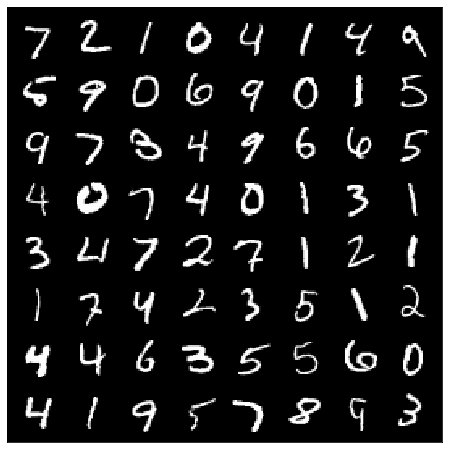

In [12]:
show_mnist(mnist_test, end=64)

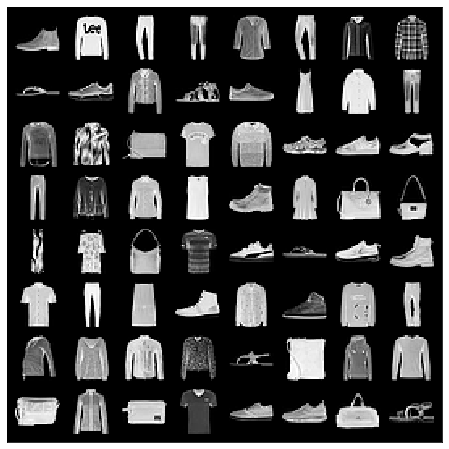

In [13]:
show_mnist(fashion_test)

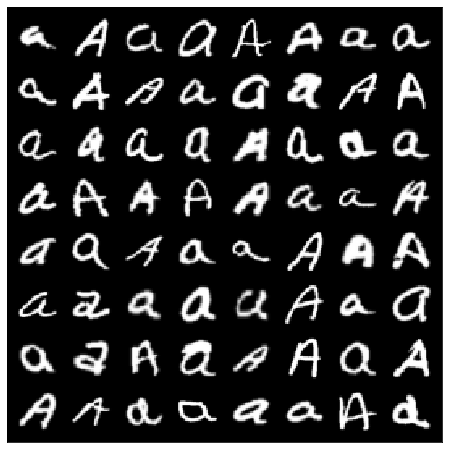

In [14]:
show_mnist(letters_test)

### DataLoader

In [15]:
batch_size = 128
test_batch_size = 512

In [16]:
train_loader = DataLoader(mnist_train, batch_size=batch_size)
valid_loader = DataLoader(mnist_valid, batch_size=test_batch_size)
test_loader = DataLoader(mnist_test, batch_size=test_batch_size)

fashion_loader = DataLoader(fashion_test, batch_size=test_batch_size)
letters_loader = DataLoader(letters_test, batch_size=test_batch_size)

### Model

$$
\Large q_{\phi}(\mathbf{z}|\mathbf{x})
$$

In [ ]:
class Encoder(nn.Module):
    '''
    (Probabilistic) Encoder
    Inference Model
    '''
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU())
        self.linear_mean = nn.Linear(400, 20)
        self.linear_log_variance = nn.Linear(400, 20)

    def reparameterize(self, mean, log_variance):
        # standad deviation
        std = torch.exp(0.5 * log_variance)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        h = self.fc1(x)
        mean = self.linear_mean(h)
        log_variance = self.linear_log_variance(h)
        z = self.reparameterize(mean, log_variance)
        return z, mean, log_variance

### Decoder
$$
\Large p_{\theta}(\mathbf{x}, \mathbf{z})
$$

In [32]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)
    
    def forward(self, z):
        h3 = F.relu(self.fc3(z))
        x_recon = torch.sigmoid(self.fc4(h3))
        return x_recon

In [33]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z, mean, log_variance = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, mean, log_variance

### Loss function

In [36]:
# Reconstruction + KL divergence losses summed over all elements and batch
# see Appendix B from VAE paper:
# Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
# https://arxiv.org/abs/1312.6114
# 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
def loss_function(x_recon, x, mean, log_variance):
    reco_error = F.binary_cross_entropy(x_recon, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp())
    return reco_error + kl_divergence

In [56]:
def train(model, data_loader, optimizer, device):
    model.train()
    accumulated_loss = 0
    
    #log_interval = int(len(data_loader) / 10)
    
    for batch_idx, (data, _) in enumerate(tqdm_notebook(data_loader)):
        data = data.to(device)
        
        optimizer.zero_grad()
        
        recon_batch, mean, log_variance = model(data)
        loss = loss_function(recon_batch, data, mean, log_variance)
        accumulated_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        # if batch_idx % log_interval == 0:
            
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(data_loader.dataset),
        #        100. * batch_idx / len(data_loader),
        #        loss.item() / len(data)))

    #average_loss = accumulated_loss / len(data_loader.dataset)
    #return average_loss

In [57]:
def test(model, data_loader, device):
    model.eval()
    accumulated_loss = 0
    
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(data_loader):
            data = data.to(device)
            recon_batch, mean, logvar = model(data)
            
            accumulated_loss += loss_function(recon_batch, data, mean, logvar).item()

    average_loss = accumulated_loss / len(data_loader.dataset)
    return average_loss

In [62]:
device = torch.device('cuda:0')
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [63]:
epochs = 10

In [64]:
for epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, device)
    
    training_loss = test(model, train_loader, device)
    validation_loss = test(model, valid_loader, device)
    print(f'[Epoch: {epoch}/{epochs + 1}] Training Loss: {training_loss:.4f}')
    print(f'[Epoch: {epoch}/{epochs + 1}] Validation Loss: {validation_loss:.4f}')


[Epoch: 1/11] Training Loss: 126.9650
[Epoch: 1/11] Validation Loss: 127.0352



[Epoch: 2/11] Training Loss: 122.6763
[Epoch: 2/11] Validation Loss: 122.9893



[Epoch: 3/11] Training Loss: 118.8157
[Epoch: 3/11] Validation Loss: 119.1384



[Epoch: 4/11] Training Loss: 118.3694
[Epoch: 4/11] Validation Loss: 118.8346



[Epoch: 5/11] Training Loss: 117.2628
[Epoch: 5/11] Validation Loss: 117.8110



[Epoch: 6/11] Training Loss: 117.2648
[Epoch: 6/11] Validation Loss: 117.9893



[Epoch: 7/11] Training Loss: 116.0168
[Epoch: 7/11] Validation Loss: 116.7956



[Epoch: 8/11] Training Loss: 116.4176
[Epoch: 8/11] Validation Loss: 117.2702



[Epoch: 9/11] Training Loss: 115.7655
[Epoch: 9/11] Validation Loss: 116.4876



[Epoch: 10/11] Training Loss: 116.5186
[Epoch: 10/11] Validation Loss: 117.4090


In [ ]:
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')